In [49]:
import numpy as np
import torch
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

connections = [[0,5],[0,7],[1,3],[1,10],[1,11],[1,8],[2,5],[2,11],[3,4],[5,10],[6,7],[6,9],[7,8]]
# Imports


# Reproducibility
seed =0
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------
# 1) Build the graph (12 nodes)
# -------------------------------
n_nodes = 12
p = 0.2  # random connection probability
u, v = 0, 5  # designated node pair with two equal shortest paths of length 3

# Start with no edges
G = nx.Graph()
G.add_nodes_from(range(n_nodes))
G.add_edges_from(connections)

adj = nx.to_numpy_array(G)
adj_t = torch.tensor(adj, dtype=torch.int64)

# -------------------------------------
# 3) Edges -> actions (both directions)
# -------------------------------------
def edges_from_adjacency(adj_matrix):
    n = adj_matrix.shape[0]
    edges = []
    action_idx = 0
    action_indices = {}
    for i in range(n):
        for j in range(i+1, n):  # Only upper triangle
            if adj_matrix[i][j] != 0:
                edges.append((i, j))
                action_indices[(i, j)] = action_idx
                action_idx += 1
                edges.append((j, i))
                action_indices[(j, i)] = action_idx
                action_idx += 1
    return edges, action_indices

edges, action_indices = edges_from_adjacency(adj_t)
a_size = len(edges)

# -------------------------------------
# 4) Random-walk dataset
# -------------------------------------

N_NODES = 12
N_EPISODES = 20
EP_LEN = 4
P_EDGE = 0.25
SEED = 1
rng_py = random.Random(SEED)
rng_np = np.random.default_rng(SEED)


def sample_episode(graph, length_nodes, rng_py, max_attempts=300):
    nodes = list(graph.nodes())
    for _ in range(max_attempts):
        path = [rng_py.choice(nodes)]
        visited = {path[0]}
        while len(path) < length_nodes:
            nbrs = [n for n in graph.neighbors(path[-1]) if n not in visited]
            if not nbrs:
                break
            nxt = rng_py.choice(nbrs)
            path.append(nxt)
            visited.add(nxt)
        if len(path) == length_nodes:
            return path
    return None

def generate_episodes(graph, n_eps, length_nodes, rng_py):
    eps = []
    for _ in range(n_eps):
        ep = sample_episode(graph, length_nodes, rng_py)
        if ep is None:
            for _ in range(200):
                ep = sample_episode(graph, length_nodes, rng_py)
                if ep is not None:
                    break
        if ep is None:
            break
        eps.append(ep)
    return eps


def draw_curved_edge(ax, p0, p1, rad=0.15, lw=3, color="tab:red", alpha=0.9):
    x0, y0 = p0
    x1, y1 = p1
    mx, my = (x0 + x1) / 2.0, (y0 + y1) / 2.0
    dx, dy = x1 - x0, y1 - y0
    dist = (dx**2 + dy**2) ** 0.5
    if dist == 0:
        return
    ux, uy = -dy / dist, dx / dist
    cx, cy = mx + rad * dist * ux, my + rad * dist * uy
    verts = [(x0, y0), (cx, cy), (x1, y1)]
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
    patch = PathPatch(Path(verts, codes), fc="none", ec=color, lw=lw, alpha=alpha)
    ax.add_patch(patch)
    
episodes = generate_episodes(G, N_EPISODES, EP_LEN, rng_py)
temp = episodes[8]
episodes[8] = episodes[11]
episodes[11] = temp
episodes[1]=[5,10,1,8]
episodes[0]=[10,5,2,11]
episodes[6]=[5,10,1,11]
episodes[12]=[3,1,10,5]
episodes[-4]=[1,8,7,6]

# The following line manually remove all episodes that goes through node 11 (with index 10)
# episodes = np.array(episodes)[[3,4,5,7,9,10,13,14,15,16,17]].tolist()

episodes = np.concatenate([episodes[10:], episodes[:10]])


# Update this following line to choose between using all episodes / first 10 episodes / later 10 episodes
episodes = episodes[:10]

# episodes= episodes[10:]
# -----------------------------
# Build directed actions & indices
# -----------------------------
o_size = N_NODES
directed_actions = []
for u, v in G.edges():
    directed_actions.append((u, v))
    directed_actions.append((v, u))
action_indices = {a: i for i, a in enumerate(directed_actions)}
a_size = len(directed_actions)

# -----------------------------
# Convert episodes (node lists) -> triplets (curr, action_idx, next)
# -----------------------------
trajectories = []
for ep in episodes:  # each ep is a list of nodes of length EP_LEN
    triplets = []
    for i in range(len(ep) - 1):
        u, v = ep[i], ep[i+1]
        a_idx = action_indices[(u, v)]
        triplets.append((u, a_idx, v))
    # store as numpy array shape (EP_LEN-1, 3)
    trajectories.append(np.array(triplets, dtype=int))

# -----------------------------
# Train Q (state embeddings) and W (action embeddings)
# -----------------------------
N = N_EPISODES         # number of trajectories you want to encode
L = EP_LEN             # nodes per trajectory
s_dim = min(N, len(trajectories))  # rows we actually fill

Q = np.zeros((s_dim, o_size), dtype=float)
W = np.zeros((a_size, s_dim), dtype=float)

# Q: each row t marks which nodes appear in trajectory t
for t, traj in enumerate(trajectories[:s_dim]):
    if traj.size == 0:
        continue
    # nodes present in the trajectory (source and target nodes)
    nodes_in_traj = set(traj[:, 0].tolist() + traj[:, 2].tolist())
    Q[t, list(nodes_in_traj)] = 1.0

# W: action embedding = resulting node's column of Q
for (start, end), idx in action_indices.items():
    W[idx, :] = Q[:, end]


In [50]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# ---------- helpers ----------
def _view_vector(ax):
    elev = float(np.deg2rad(np.asarray(ax.elev).item()))
    azim = float(np.deg2rad(np.asarray(ax.azim).item()))
    return np.array([np.cos(elev)*np.cos(azim),
                     np.cos(elev)*np.sin(azim),
                     np.sin(elev)], dtype=float)

def _great_circle_points(p, q, r=1.0, n=128, lift=1.002):
    p = np.asarray(p, float); q = np.asarray(q, float)
    p = p / (np.linalg.norm(p) + 1e-12)
    q = q / (np.linalg.norm(q) + 1e-12)
    dot = np.clip(np.dot(p, q), -1.0, 1.0); omg = np.arccos(dot)
    if omg < 1e-6:
        pts = np.tile(p, (n, 1))
    elif np.pi - omg < 1e-6:
        axis = np.cross(p, [1,0,0]); 
        if np.linalg.norm(axis) < 1e-6: axis = np.cross(p, [0,1,0])
        axis /= np.linalg.norm(axis) + 1e-12
        ts = np.linspace(0, np.pi, n)
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        I = np.eye(3); out = []
        for t in ts:
            ct, st = np.cos(t), np.sin(t)
            R = ct*I + st*K + (1-ct)*np.outer(axis, axis)
            out.append(R @ p)
        pts = np.vstack(out)
    else:
        ts = np.linspace(0.0, 1.0, n)
        so = np.sin(omg)
        pts = (np.sin((1-ts)*omg)[:,None]*p + np.sin(ts*omg)[:,None]*q) / (so + 1e-12)
    return (r*lift) * pts

def _segment_front_back(pts, vdir, iters=12):
    pts = np.asarray(pts, float).reshape(-1, 3)
    vdir = np.asarray(vdir, float).reshape(3,)
    u = pts / (np.linalg.norm(pts, axis=1, keepdims=True) + 1e-12)
    s = u @ vdir
    segs, cur_pts = [], [pts[0]]
    cur_front = s[0] >= 0
    for i in range(1, len(pts)):
        same = (s[i] >= 0) == cur_front
        if same:
            cur_pts.append(pts[i])
        else:
            a, b = pts[i-1], pts[i]
            t0, t1 = 0.0, 1.0
            for _ in range(iters):
                t = 0.5*(t0 + t1)
                m = a*(1-t) + b*t
                m /= (np.linalg.norm(m) + 1e-12)
                val = np.dot(m, vdir)
                if (val >= 0) == cur_front: t0 = t
                else:                        t1 = t
            x = a*(1-t1) + b*t1
            cur_pts.append(x); segs.append((np.vstack(cur_pts), cur_front))
            cur_pts = [x, pts[i]]; cur_front = not cur_front
    segs.append((np.vstack(cur_pts), cur_front))
    return segs

def _labels_on_top(ax, pos, labels=None, pixel_offset=10):
    if labels is None:
        labels = list(range(len(pos)))
    M = ax.get_proj()
    for i, (x, y, z) in pos.items():
        x2, y2, _ = proj3d.proj_transform(x, y, z, M)
        ax.annotate(str(labels[i]), xy=(x2, y2), xycoords=ax.transData,
                    xytext=(0, pixel_offset), textcoords="offset points",
                    ha="center", va="bottom", zorder=10,
                    path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)])

from mpl_toolkits.mplot3d import proj3d
import matplotlib.patheffects as pe

def labels_on_top_aligned(ax, plot_pos, pixel_offset=10):
    """
    plot_pos: dict[node_id] -> 3D coords actually used to draw the node.
    Labels are projected from those coords, so they sit on the dots.
    """
    M = ax.get_proj()
    for i, (x, y, z) in plot_pos.items():
        x2, y2, _ = proj3d.proj_transform(x, y, z, M)
        ax.annotate(
            str(i),
            xy=(x2, y2), xycoords=ax.transData,
            xytext=(0, pixel_offset), textcoords="offset points",
            ha="center", va="bottom", zorder=10,
            path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
        )

# ---------- main ----------
def run_t_sne_3d_raw(
    Q, W, G, action_indices,
    perp=12, early_exaggeration=3, learning_rate=20,
    start=None, goal=None,
    r=1.0,
    sphere_alpha=0.02, sphere_cmap="viridis",
    line_alpha=1.0,
    rng_seed=42,
    azim=None, elev=None,
    show_labels=True,
):
    """
    3D node embedding (PCA→sphere). Geodesic edges split into front/back.
    To make ordering robust on older Matplotlib, we 'nudge' front segments slightly
    toward the camera and back nodes slightly away from it.
    """
    # --- data prep ---
    Q = np.asarray(Q, float)           # (s_dim, o_size)
    W = np.asarray(W, float)           # (a_size, s_dim)
    X = Q.T.copy()                     # (o_size, s_dim)
    n = X.shape[0]
    print(X)
    P = PCA(n_components=3, random_state=rng_seed).fit_transform(X)
    P[:,0] = -1*P[:,0]
    P[:,1] = -1*P[:,1]
#     P[:,2] = -1*P[:,2] # only this for removing node 11
    print(P)
    P = r * P / np.linalg.norm(P, axis=1, keepdims=True)#np.maximum(, 1e-12)
    pos = {i: P[i] for i in range(n)}

    # --- edge source 
    edge_source = G.__class__()  # preserve type
    util_color = None
    edge_source = G

    # --- figure & sphere ---
    fig = plt.figure(figsize=(10, 8), dpi=160)
    ax = fig.add_subplot(111, projection="3d")
    if (elev is not None) or (azim is not None):
        ax.view_init(elev=(ax.elev if elev is None else elev),
                     azim=(ax.azim if azim is None else azim))

    u = np.linspace(0, 2*np.pi, 80); v = np.linspace(0, np.pi, 40)
    xs = 0.99*r * np.outer(np.cos(u),  np.sin(v))
    ys = 0.99*r * np.outer(np.sin(u),  np.sin(v))
    zs = 0.99*r * np.outer(np.ones_like(u), np.cos(v))
    norm = plt.Normalize(zs.min(), zs.max())
    facecols = plt.cm.get_cmap(sphere_cmap)(norm(zs))
    ax.plot_surface(xs, ys, zs, rstride=2, cstride=2,
                    facecolors=facecols, edgecolor=(0,0,0,0.05),
                    linewidth=0.3, antialiased=False,
                    alpha=sphere_alpha, shade=False, zorder=0)

    # --- EDGES: geodesics split front/back, with camera-direction nudge ---
    default_edge_rgba = (0, 0, 0, line_alpha)
    vdir = _view_vector(ax)
    eps_front = 0.01 * r   # tiny nudge toward camera
    eps_back  = 0.01 * r   # tiny nudge away from camera

    for u_, v_ in edge_source.edges():
        print(u_,v_)
#         if u_==10 or v_==10:
#             continue
        col = default_edge_rgba
        arc = _great_circle_points(pos[u_], pos[v_], r=r, n=128, lift=1.00)
        for seg, is_front in _segment_front_back(arc, vdir):
            if len(seg) < 2: 
                continue
            if is_front:
                seg2 = seg #+ eps_front * vdir   # bring slightly closer
                ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                        color=col, lw=2.5, zorder=4, solid_capstyle="round")
            else:
                seg2 = seg #- eps_back * vdir    # push slightly farther
                ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                        color=(0.2,0.2,0.2,0.4), lw=2.5, zorder=1, solid_capstyle="round")

    # --- NODES: split back/front; push back nodes slightly away from camera ---
    front_nodes, back_nodes = [], []
    for i, p in pos.items():
        front_nodes.append(i) if np.dot(p/np.linalg.norm(p), vdir) >= 0 else back_nodes.append(i)

    for i in back_nodes:
        
        p = np.asarray(pos[i]); p2 = p - eps_back * vdir
        ax.scatter(*p2, s=800, marker="o",
                   facecolors=(0.7,0.7,0.7,0.25), edgecolors=(0.3,0.3,0.3,0.5),
                   linewidths=1.4, depthshade=False, zorder=2)

    for i in front_nodes:
#         if i==10:
#             continue
        p = np.asarray(pos[i])  # no nudge needed; front edges are already nudged closer
        ax.scatter(*p, s=800, marker="o",
                   facecolors="white", edgecolors="black",
                   linewidths=2.0, depthshade=False, zorder=5)

    # --- LABELS: 2D annotations so they’re always visible ---
    def add_3d_labels_on_top(ax, pos, labels=None, pixel_offset=8):
        """
        Draw labels as 2D annotations projected from 3D, so they can't be occluded
        by 3D markers. `pixel_offset` moves text away from the node in screen pixels.
        """
        if labels is None:
            labels = list(range(len(pos)))
        proj = ax.get_proj()
        for i, (x, y, z) in enumerate(pos.values()):
            x2, y2, _ = proj3d.proj_transform(x, y, z, proj)
            ax.annotate(
                str(labels[i]+1),
                xy=(x2, (y2-0.005)*1.1), xycoords=ax.transData,
                xytext=(0, pixel_offset), textcoords="offset points",
                ha="center", va="bottom",
                zorder=10000,
                path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)],
            )
#     ax.view_init(elev=30, azim=45)
    # call it:
    if show_labels:
        add_3d_labels_on_top(ax, pos, labels=list(range(n)), pixel_offset=10)

    # --- cosmetics ---
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_box_aspect([1,1,1])
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor((1,1,1,0))
        axis.pane.set_facecolor((1,1,1,0.08))
    ax.grid(True)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return fig, ax


In [51]:
import numpy as np

def view_vector(ax):
    elev = float(np.deg2rad(np.asarray(ax.elev).item()))
    azim = float(np.deg2rad(np.asarray(ax.azim).item()))
    return np.array([
        np.cos(elev) * np.cos(azim),
        np.cos(elev) * np.sin(azim),
        np.sin(elev)
    ], dtype=float)

def segment_by_front_back(pts, vdir, iters=12):
    """
    Split a 3D polyline into front/back segments w.r.t. vdir.
    Inserts intersection points where dot(unit(p), vdir) = 0.
    Returns list of (segment_points, is_front_bool).
    """
    pts = np.asarray(pts, float).reshape(-1, 3)   # (N,3)
    vdir = np.asarray(vdir, float).reshape(3,)    # (3,)
    u = pts / (np.linalg.norm(pts, axis=1, keepdims=True) + 1e-12)
    s = u @ vdir  
    segs = []

    cur_pts = [pts[0]]
    cur_front = s[0] >= 0

    for i in range(1, len(pts)):
        same_side = (s[i] >= 0) == cur_front
        if same_side:
            cur_pts.append(pts[i])
        else:
            # crossing between pts[i-1] -> pts[i]; find intersection by bisection
            a, b = pts[i-1], pts[i]
            t0, t1 = 0.0, 1.0
            for _ in range(iters):
                t = 0.5*(t0 + t1)
                m = a*(1-t) + b*t
                m /= np.linalg.norm(m)
                val = np.dot(m, vdir)
                if (val >= 0) == cur_front:
                    t0 = t
                else:
                    t1 = t
            x = a*(1-t1) + b*t1  # crossing point in data coords
            cur_pts.append(x)
            segs.append((np.vstack(cur_pts), cur_front))
            # start new segment on the other side
            cur_pts = [x, pts[i]]
            cur_front = not cur_front

    segs.append((np.vstack(cur_pts), cur_front))
    return segs

def draw_geodesic_edge_split_precise(ax, u, v, color, r=1.0, n=128,
                                     lift=1.002, gray=(0.5,0.5,0.5,0.35),
                                     lw_front=2.2, lw_back=1.4):
    arc = great_circle_points(pos[u], pos[v], r=r, n=n, lift=lift)  # your SLERP from earlier
    vdir = view_vector(ax)
    for seg, is_front in segment_by_front_back(arc, vdir):
        if len(seg) < 2: 
            continue
        if is_front:
            ax.plot(seg[:,0], seg[:,1], seg[:,2], color=color, lw=lw_front, zorder=3, solid_capstyle="round")
        else:
            ax.plot(seg[:,0], seg[:,1], seg[:,2], color=gray, lw=lw_back, zorder=1, solid_capstyle="round")


In [52]:
import numpy as np

def great_circle_points(p, q, r=1.0, n=64, lift=1.001):
    """
    Return n points along the great-circle arc from p to q on a sphere.
    p, q: 3D vectors (not necessarily unit). r: sphere radius.
    lift>1 slightly raises the curve off the sphere to avoid z-fighting.
    """
    p = np.asarray(p, float); q = np.asarray(q, float)
    p = p / (np.linalg.norm(p) + 1e-12)
    q = q / (np.linalg.norm(q) + 1e-12)

    # Angle between p and q
    dot = np.clip(np.dot(p, q), -1.0, 1.0)
    omega = np.arccos(dot)

    # Handle near-identical and near-antipodal cases
    if omega < 1e-6:
        pts = np.tile(p, (n, 1))
    elif np.pi - omega < 1e-6:
        # Antipodal: pick an arbitrary orthogonal axis to define the arc
        axis = np.cross(p, np.array([1.0, 0.0, 0.0]))
        if np.linalg.norm(axis) < 1e-6:
            axis = np.cross(p, np.array([0.0, 1.0, 0.0]))
        axis /= np.linalg.norm(axis)
        # rotate p around axis from 0..π
        ts = np.linspace(0, np.pi, n)
        pts = []
        for t in ts:
            ct, st = np.cos(t), np.sin(t)
            R = (ct * np.eye(3) +
                 st * np.array([[0, -axis[2], axis[1]],
                                [axis[2], 0, -axis[0]],
                                [-axis[1], axis[0], 0]]) +
                 (1-ct) * np.outer(axis, axis))
            pts.append(R @ p)
        pts = np.vstack(pts)
    else:
        # Standard SLERP
        ts = np.linspace(0.0, 1.0, n)
        sin_omega = np.sin(omega)
        pts = ((np.sin((1-ts) * omega)[:, None] * p +
                np.sin(ts * omega)[:, None] * q) / sin_omega)

    return (r * lift) * pts  # lift slightly above sphere


[[1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[-0.65544716  0.98299533  0.01925875]
 [ 0.87473474 -1.54230008 -0.26633415]
 [ 0.19213368  0.74230562  0.21254641]
 [ 1.0623387   0.02547778  0.75787403]
 [ 0.71602634  0.1879394   1.04536093]
 [ 0.8342667   0.50313285 -0.71618832]
 [-1.54835478 -0.19355807 -0.06803403]
 [-1.55029305 -0.69107225 -0.32917262]
 [-0.5147379  -1.28144302  0.45923513]
 [-1.06686842  0.79999446  0.05378774]
 [ 1.16824678 -0.19906648 -0.73963247]
 [ 0.48795435  0.66559447 -0.42870141]]
0 5
0 7
1 3
1 10
1 11
1 8
2 5
2 11
3 4
5 10
6 7
6 9
7 8


/tmp/ipykernel_3607596/3606614491.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  facecols = plt.cm.get_cmap(sphere_cmap)(norm(zs))


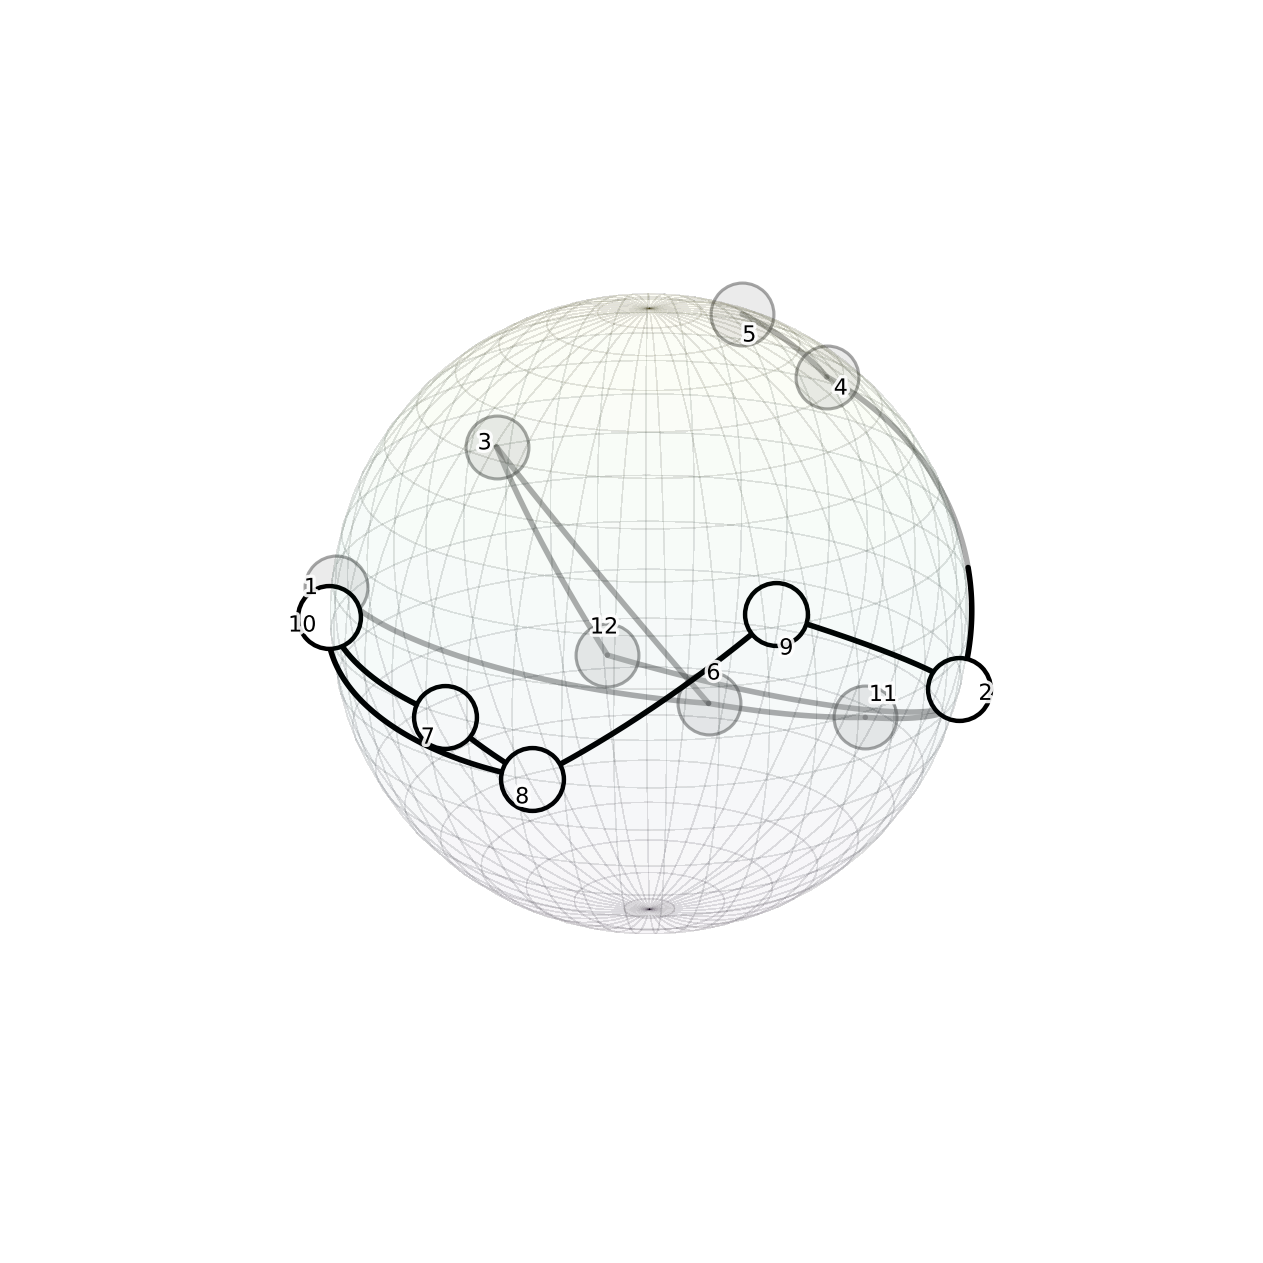

In [53]:
# Q = np.random.randn(20,12)
# Example call (assuming you have Q, W, G, action_indices defined)
fig, ax = run_t_sne_3d_raw(
    Q, W, G, action_indices,
    perp=5, r=1.0,
    azim=225, elev=20, show_labels=True
)


In [54]:
def _build_directed_actions(G):
    acts = []
    for u, v in G.edges():
        acts.append((u, v)); acts.append((v, u))
    a_idx = {a: i for i, a in enumerate(acts)}
    return acts, a_idx, len(acts)

def _apply_weights(Q, classes, wA, wB):
    weights = np.array([wA if c=="A" else wB for c in classes[:Q.shape[0]]], float)
    return weights[:, None] * Q, weights

def _plan_numpy(start, goal, G, acts, a_idx, Qw, W):
    start-=1
    goal-=1
    a_size, n_nodes = len(acts), G.number_of_nodes()
    afford = {i: [] for i in range(n_nodes)}
    for (s, e) in acts: afford[s].append(a_idx[(s, e)])
    a_rec, o_rec, loc = [], [], int(start)
    for _ in range(n_nodes+1):
        o_rec.append(loc+1)
        if loc == goal: break
        mask = np.full((a_size,), -np.inf); mask[afford[loc]] = 1.0
        mask_fix = mask.copy()
        goal_vec = Qw[:, goal]
        util = (W @ goal_vec).copy(); util[mask==-np.inf] = -np.inf
        aidx = int(np.nanargmax(util)) if np.isfinite(util).any() else int(np.nanargmax((W @ goal_vec)*(mask_fix>0)))
        _, loc = acts[aidx]
        a_rec.append(aidx+1)
    return o_rec, a_rec

In [55]:
acts, a_idx, _ = _build_directed_actions(G)
#plan a path from node 1 to node 2
nodes, actions = _plan_numpy(1,2,G,acts,a_idx,Q,W)
print('planned path:', nodes)
print('used actions:', actions)

planned path: [1, 8, 9, 2]
used actions: [3, 25, 12]


In [88]:
import numpy as np
import torch
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

connections = [[0,5],[0,7],[1,3],[1,10],[1,11],[1,8],[2,5],[2,11],[3,4],[5,10],[6,7],[6,9],[7,8]]

N_NODES = 12
N_EPISODES = 20
EP_LEN = 4
P_EDGE = 0.25
SEED = 1
rng_py = random.Random(SEED)
rng_np = np.random.default_rng(SEED)


def sample_episode(graph, length_nodes, rng_py, max_attempts=300):
    nodes = list(graph.nodes())
    for _ in range(max_attempts):
        path = [rng_py.choice(nodes)]
        visited = {path[0]}
        while len(path) < length_nodes:
            nbrs = [n for n in graph.neighbors(path[-1]) if n not in visited]
            if not nbrs:
                break
            nxt = rng_py.choice(nbrs)
            path.append(nxt)
            visited.add(nxt)
        if len(path) == length_nodes:
            return path
    return None

def generate_episodes(graph, n_eps, length_nodes, rng_py):
    eps = []
    for _ in range(n_eps):
        ep = sample_episode(graph, length_nodes, rng_py)
        if ep is None:
            for _ in range(200):
                ep = sample_episode(graph, length_nodes, rng_py)
                if ep is not None:
                    break
        if ep is None:
            break
        eps.append(ep)
    return eps


def draw_curved_edge(ax, p0, p1, rad=0.15, lw=3, color="tab:red", alpha=0.9):
    x0, y0 = p0
    x1, y1 = p1
    mx, my = (x0 + x1) / 2.0, (y0 + y1) / 2.0
    dx, dy = x1 - x0, y1 - y0
    dist = (dx**2 + dy**2) ** 0.5
    if dist == 0:
        return
    ux, uy = -dy / dist, dx / dist
    cx, cy = mx + rad * dist * ux, my + rad * dist * uy
    verts = [(x0, y0), (cx, cy), (x1, y1)]
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
    patch = PathPatch(Path(verts, codes), fc="none", ec=color, lw=lw, alpha=alpha)
    ax.add_patch(patch)
    
episodes = generate_episodes(G, N_EPISODES, EP_LEN, rng_py)
temp = episodes[8]
episodes[8] = episodes[11]
episodes[11] = temp
episodes[1]=[5,10,1,8]
episodes[0]=[10,5,2,11]
episodes[6]=[5,10,1,11]
episodes[12]=[3,1,10,5]
episodes[-4]=[1,8,7,6]

# Manually select episodes that do not contain node 11 (with index 10)
# Try remove the following line to see the original planning using all episodes
episodes = np.array(episodes)[[3,4,5,7,9,10,13,14,15,16,17]].tolist()

o_size = N_NODES
directed_actions = []
for u, v in G.edges():
    directed_actions.append((u, v))
    directed_actions.append((v, u))
action_indices = {a: i for i, a in enumerate(directed_actions)}
a_size = len(directed_actions)

# -----------------------------
# Convert episodes (node lists) -> triplets (curr, action_idx, next)
# -----------------------------
trajectories = []
for ep in episodes:  # each ep is a list of nodes of length EP_LEN
    triplets = []
    for i in range(len(ep) - 1):
        u, v = ep[i], ep[i+1]
        a_idx = action_indices[(u, v)]
        triplets.append((u, a_idx, v))
    # store as numpy array shape (EP_LEN-1, 3)
    trajectories.append(np.array(triplets, dtype=int))

# -----------------------------
# Train Q (state embeddings) and W (action embeddings)
# -----------------------------
N = N_EPISODES         # number of trajectories you want to encode
L = EP_LEN             # nodes per trajectory
s_dim = min(N, len(trajectories))  # rows we actually fill

Q = np.zeros((s_dim, o_size), dtype=float)
W = np.zeros((a_size, s_dim), dtype=float)

# Q: each row t marks which nodes appear in trajectory t
for t, traj in enumerate(trajectories[:s_dim]):
    if traj.size == 0:
        continue
    # nodes present in the trajectory (source and target nodes)
    nodes_in_traj = set(traj[:, 0].tolist() + traj[:, 2].tolist())
    Q[t, list(nodes_in_traj)] = 1.0

# W: action embedding = resulting node's column of Q
for (start, end), idx in action_indices.items():
    W[idx, :] = Q[:, end]


In [89]:
acts, a_idx, _ = _build_directed_actions(G)
#plan a path from node 1 to node 2
nodes, actions = _plan_numpy(6,2,G,acts,a_idx,Q,W)
print('planned path:', nodes)
print('used actions:', actions)

planned path: [6, 3, 12, 2]
used actions: [14, 15, 10]
